#### Import required packages

In [1]:
# numeric and plotting libraries
import time
import os
import shutil
import math
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import csv
import random
from PIL import Image
import csv
import operator 
import pandas as pd 
# to create confusion metrics
import seaborn as sns
import scipy.io as sio
from cmath import nan
from cmath import isnan

In [142]:
from ipynb.fs.full.data_prep import *

In [3]:
%matplotlib inline

In [4]:
from sklearn.metrics import accuracy_score,confusion_matrix # metrics error
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Classification on anest and awake state

#### Data preparation

In [157]:
def ucitavanje_podataka(directory):
    id = 0
    data = []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        label = f.split("\\")[-1][0:2]
        id = id + 1
        dat = np.load(f)
        data.append([id, dat, label])
    
    #random.seed(2)
    random.shuffle(data)
    return data      

In [150]:
def vektorizacija(podaci):
    prevodjenje_labela = {"an": [1], "aw": [0]}  # TRUE:Mirtrons  FALSE:canonical microRN

    vektorizovani_podaci = []
    for a in podaci:
        vektorizovani_podaci.append([a[0], a[1], prevodjenje_labela[a[2]]])

    return vektorizovani_podaci

In [126]:
def podela_podataka(data_vectors):
    max = 0
    for i in range(0,len(data_vectors)):
        if(data_vectors[i][1].shape[0] > max):
            max = data_vectors[i][1].shape[0]

    X_train, y_train, X_test, y_test = np.empty([1, max, data_vectors[0][1].shape[1]]), [], np.empty([1, max, data_vectors[0][1].shape[1]]),[]
    i,j = 0,0

    random.shuffle(data_vectors)
    for item in data_vectors:
        if item[2]==[1]:
            i = i + 1
            if i <= 50:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant' , constant_values=0)
                X_test = np.append(X_test, np.array(item[1]).reshape(1, item[1].shape[0], np.array(item[1]).shape[1]), axis=0)
                y_test.append(item[2])
                #y_test.append(random.choice([[0], [1]]))
            else:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)
                X_train = np.append(X_train, np.array(item[1]).reshape(1, np.array(item[1]).shape[0], np.array(item[1]).shape[1]), axis=0)
                y_train.append(item[2])
        else:
            j = j + 1
            if  j <= 50:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)
                X_test = np.append(X_test, np.array(item[1]).reshape(1, np.array(item[1]).shape[0], np.array(item[1]).shape[1]), axis=0)
                y_test.append(item[2])
                #y_test.append(random.choice([[0], [1]]))
            else:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)
                X_train = np.append(X_train, np.array(item[1]).reshape(1, np.array(item[1]).shape[0], np.array(item[1]).shape[1]), axis=0)
                y_train.append(item[2])
    
    X_train = np.array(X_train[1:])
    y_train = np.array(y_train)
    X_test = np.array(X_test[1:])
    y_test = np.array(y_test)
    
    return X_train, y_train, X_test, y_test

In [127]:
def podela_podataka_tren(data_vectors):
    max = 110
    X_train, y_train = np.empty([1, max, data_vectors[0][1].shape[1]]), []

    random.shuffle(data_vectors)

    for item in data_vectors:
        if(item[1].shape[0] < max):
            item[1] = np.pad(item[1], [(0, max-item[1].shape[0]), (0, 0)], mode='constant', constant_values=0)      
        X_train = np.append(X_train, item[1].reshape(1, item[1].shape[0], item[1].shape[1]), axis=0)
        #y_train.append(item[2])
        y_train.append(random.choice([[0], [1]]))
    
    X_train = np.array(X_train[1:])
    y_train = np.array(y_train)
    
    return X_train, y_train

#### Test/Train

In [ ]:
#putanja = "C:/Users/Zephyrus/Desktop/cnn data/data"
putanja = "C:/Users/m.nedeljkovic/Desktop/cnn data/data"
#niz od podataka za svaku sekvencu (podatak je niz od id-ja, sekvence i labele)
podaci = ucitavanje_podataka(putanja)
vektorizovani_podaci = vektorizacija(podaci)

X_train, y_train, X_test, y_test = podela_podataka(vektorizovani_podaci)
X_train = np.array(X_train, dtype=object)
y_train = np.array(y_train)
X_test = np.array(X_test, dtype=object)
y_test = np.array(y_test)

In [130]:
X_tr = []
for i in X_train:
    temp = []
    for j in i:
        for k in j:
            if(isnan(k)):
                k = 0
            temp.append(k)
    X_tr.append(temp)
X_train = np.array(X_tr, dtype=object)

X_ts = []
for i in X_test:
    temp = []
    for j in i:
        for k in j:
            if(isnan(k)):
                k = 0
            temp.append(k)
    X_ts.append(temp) 
X_test = np.array(X_ts, dtype=object)

### KNN

In [131]:
knn = OneVsRestClassifier(KNeighborsClassifier())
knn.fit(X_train,y_train)

OneVsRestClassifier(estimator=KNeighborsClassifier())

In [132]:
predictions = knn.predict(X_test)

In [133]:
print('KNN Accuracy: %.3f' % accuracy_score(y_test,predictions))

KNN Accuracy: 0.950


Text(0.5, 1.0, 'Accuracy Score: 0.95')

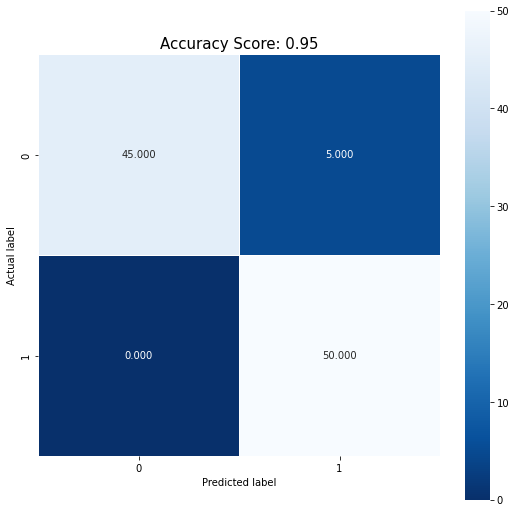

In [134]:
cm = confusion_matrix(y_test,predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm,annot=True, fmt='.3f', linewidths=.5, square=True,cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test,predictions))
plt.title(all_sample_title,size=15)

### Random Forest

##### Implementation

In [135]:
def RF(X_train, y_train, X_test, y_test):
    forest = RandomForestClassifier(criterion='gini',
                                    n_estimators=5,
                                    random_state=1,
                                    n_jobs=2)

    forest.fit(X_train, y_train)

    y_pred = forest.predict(X_test)

    print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
    
    return y_pred

In [136]:
def mat_of_conf(y_test,y_pred,br1,br2):
    cm = confusion_matrix(y_test,y_pred)

    plt.figure(figsize=(9,9))
    sns.heatmap(cm,annot=True, fmt='.3f', linewidths=.5, square=True,cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test,y_pred))
    plt.title(all_sample_title,size=15)
    plt.savefig("C:/Users/m.nedeljkovic/Desktop/ses/ses_" + str(br1) + "_" + str(br2) + ".jpeg")

In [ ]:
Forest = RF(X_train, y_train, X_test, y_test)
mat_of_conf(y_test,Forest)

##### Iterating over different regions

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from cmath import isnan

#putanja = "C:/Users/Zephyrus/Desktop/cnn data/data"
putanja = "C:/Users/m.nedeljkovic/Desktop/cnn data/data"
mat_load, roi_load, ind_load, list1, list2, list3, list4 = load_data()

for br1 in range(1,13):
    for br2 in range(1,13):
        if(br1!=br2):
            print("Trained on region " + str(br1) + ", and tested on region " + str(br2))

            for file_name in os.listdir(putanja):
                # construct full file path
                file = putanja + "/" + file_name
                os.remove(file)

            mat_load, roi_load, ind_load, list1, list2, list3, list4 = load_data()
            data_per_trial(1, mat_load, roi_load, ind_load, list1, list2, list3, list4)

            #niz od podataka za svaku sekvencu (podatak je niz od id-ja, sekvence i labele)
            podaci = ucitavanje_podataka(putanja)
            vektorizovani_podaci = vektorizacija(podaci)

            X_train, y_train, X_test, y_test = podela_podataka(vektorizovani_podaci)
            X_train = np.array(X_train, dtype=object)
            y_train = np.array(y_train)
            X_test = np.array(X_test, dtype=object)
            y_test = np.array(y_test)

            X_tr = []
            for i in X_train:
                temp = []
                for j in i:
                    for k in j:
                        if(isnan(k)):
                            k = 0
                        temp.append(k)
                X_tr.append(temp)
            X_train = np.array(X_tr, dtype=object)

            X_ts = []
            for i in X_test:
                temp = []
                for j in i:
                    for k in j:
                        if(isnan(k)):
                            k = 0
                        temp.append(k)
                X_ts.append(temp) 
            X_test = np.array(X_ts, dtype=object)
            Forest = RF(X_train, y_train, X_test, y_test)
            mat_of_conf(y_test,Forest,br1,br2)


### Iterating over different sessions knn and rf

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy: 0.530
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


KeyboardInterrupt: 

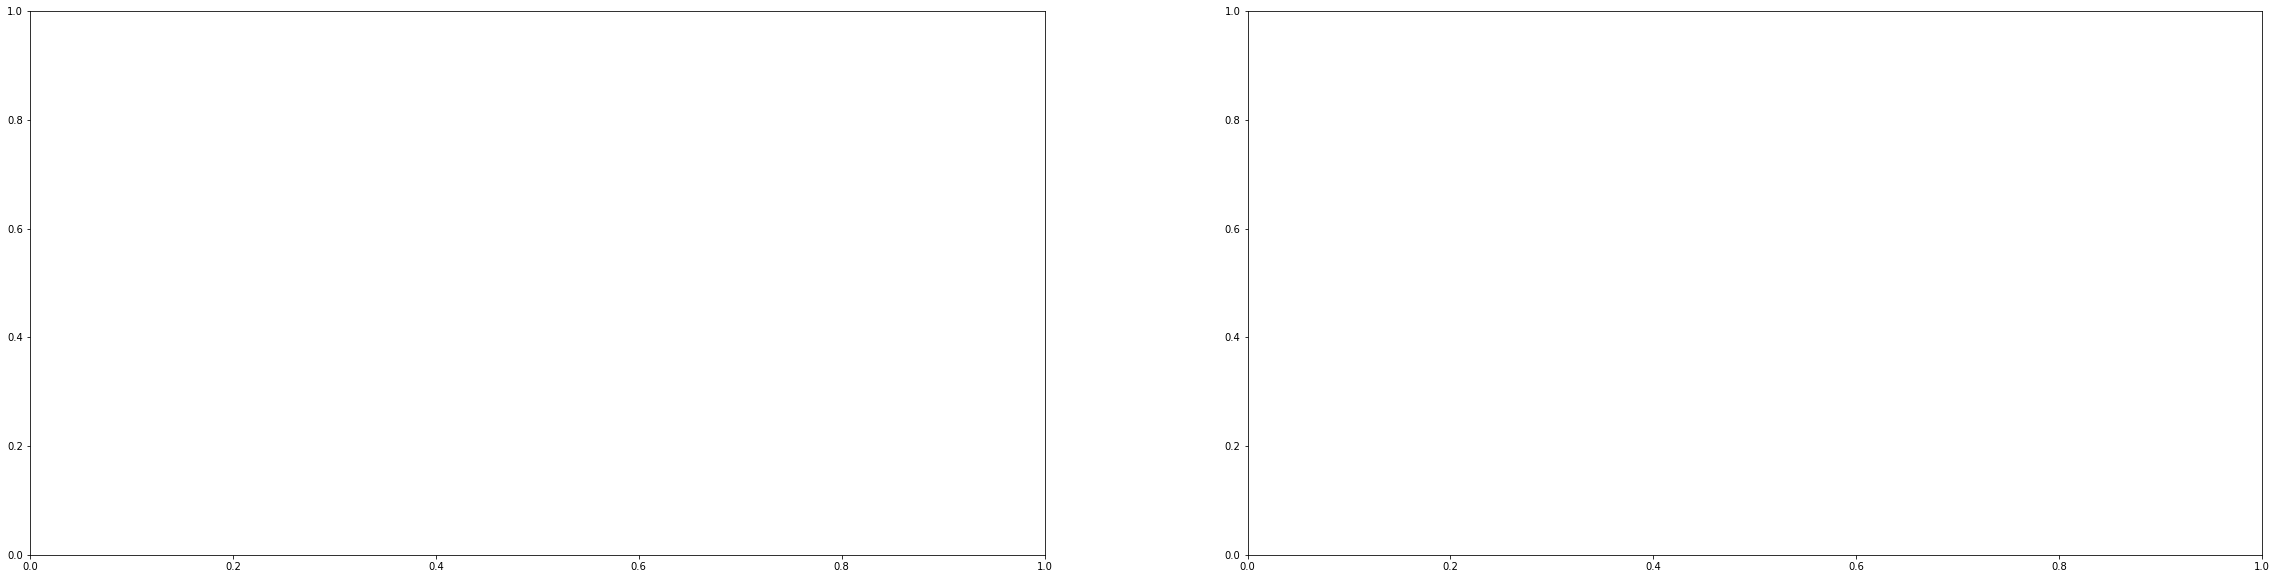

In [161]:
import warnings
warnings.filterwarnings('ignore')

#putanja = "C:/Users/Zephyrus/Desktop/cnn data/data"
putanja = "C:/Users/m.nedeljkovic/Desktop/cnn data/data"

mat_load, roi_load, ind_load, list1, list2, list3, list4 = load_data()

for tr in range(1,13):

    f,(ax1,ax2) = plt.subplots(1,2,sharey=False,figsize=(40, 10))

    for br1 in range(0, 4):
        knn_val = []
        rf_val = []
        t = []
        
        for br2 in range(0, 4):
            if(br1 != br2):
                t.append(float(br2))

                for file_name in os.listdir(putanja):
                    # construct full file path
                    file = putanja + "/" + file_name
                    os.remove(file)

                data_per_ses(tr, br1, mat_load, roi_load, ind_load, list1, list2, list3, list4)
                podaci = ucitavanje_podataka(putanja)





                print(podaci[1][1][15])





                
                vektorizovani_podaci = vektorizacija(podaci)
                X_train_, y_train_ = podela_podataka_tren(vektorizovani_podaci)
                X_tr = []
                for i in X_train_:
                    temp = []
                    for j in i:
                        for k in j:
                            if(isnan(k)):
                                k = 0
                            temp.append(k)
                    X_tr.append(temp)
                X_train_ = np.nan_to_num(X_tr)

                for file_name in os.listdir(putanja):
                    # construct full file path
                    file = putanja + "/" + file_name
                    os.remove(file)

                data_per_ses(tr, br2, mat_load, roi_load, ind_load, list1, list2, list3, list4)
                podaci = ucitavanje_podataka(putanja)
                vektorizovani_podaci = vektorizacija(podaci)
                X_test_, y_test_ = podela_podataka_tren(vektorizovani_podaci)
                
                X_ts = []
                for i in X_test_:
                    temp = []
                    for j in i:
                        for k in j:
                            if(isnan(k)):
                                k = 0
                            temp.append(k)
                    X_ts.append(temp) 
                X_test_ = np.nan_to_num(X_ts)
            
                knn = OneVsRestClassifier(KNeighborsClassifier())
                knn.fit(X_train_,y_train_)
                predictions = knn.predict(X_test_)
                knn_acc = accuracy_score(y_test_,predictions)

                Forest = RF(X_train_, y_train_, X_test_, y_test_)
                rf = accuracy_score(y_test,Forest)

                knn_val.append(knn_acc)
                rf_val.append(rf)

        ax1.scatter( t, knn_val, label = "(Region " + str(tr) + ") Trained on session " + str(br1+1) )
        ax1.plot(t, knn_val, '-')
        ax2.scatter( t, rf_val, label = "(Region " + str(tr) + ") Trained on session " + str(br1+1) )
        ax2.plot(t, rf_val, '-')

    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('different sessions')
    ax2.set_xlabel('different sessions')
    ax2.set_ylabel('accuracy')

    ax1.set_title("KNN")
    ax2.set_title("Random Forest")
    f.suptitle("Region " + str(tr) + " - training and evaluationg on different sessions")
    plt.legend()
    plt.show()

# Classification on 5 different speakers

#### Data preparation

In [107]:
def ucitavanje_sp(directory):
    id = 0
    data = []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        label = [int(f.split("\\")[-1][-5:-4])]
        id = id + 1
        dat = np.load(f)
        data.append([id, dat, label])
    
    #random.seed(2)
    random.shuffle(data)
    return data      

In [108]:
def podela_podataka_sp(data_vectors):
    max = 0
    for i in range(0,len(data_vectors)):
        if(data_vectors[i][1].shape[0] > max):
            max = data_vectors[i][1].shape[0]

    X_train, y_train, X_test, y_test = np.empty([1, max, data_vectors[0][1].shape[1]]), [], np.empty([1, max, data_vectors[0][1].shape[1]]),[]
    
    i1,i2,i3,i4,i5 = 0,0,0,0,0

    random.shuffle(data_vectors)
    for item in data_vectors:
        if item[2]==[0]:

            i1 = i1 + 1
            if i1 <= 50:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant' , constant_values=0)

                X_test = np.append(X_test, item[1].reshape(1, item[1].shape[0], item[1].shape[1]), axis=0)
                y_test.append(item[2])
                #y_test.append(random.choice([[0], [1]]))
            else:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)
                X_train = np.append(X_train, item[1].reshape(1, item[1].shape[0], item[1].shape[1]), axis=0)
                y_train.append(item[2])
        elif item[2]==[1]:
            i2 = i2 + 1
            if  i2 <= 50:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)

                X_test = np.append(X_test, item[1].reshape(1, item[1].shape[0], item[1].shape[1]), axis=0)
                y_test.append(item[2])
                #y_test.append(random.choice([[0], [1]]))
            else:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)
                X_train = np.append(X_train, item[1].reshape(1, item[1].shape[0], item[1].shape[1]), axis=0)
                y_train.append(item[2])
        elif item[2]==[2]:
            i3 = i3 + 1
            if  i3 <= 50:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)

                X_test = np.append(X_test, item[1].reshape(1, item[1].shape[0], item[1].shape[1]), axis=0)
                y_test.append(item[2])
                #y_test.append(random.choice([[0], [1]]))
            else:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)
                X_train = np.append(X_train, item[1].reshape(1, item[1].shape[0], item[1].shape[1]), axis=0)
                y_train.append(item[2])

        elif item[2]==[3]:
            i4 = i4 + 1
            if  i4 <= 50:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)

                X_test = np.append(X_test, item[1].reshape(1, item[1].shape[0], item[1].shape[1]), axis=0)
                y_test.append(item[2])
                #y_test.append(random.choice([[0], [1]]))
            else:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)
                X_train = np.append(X_train, item[1].reshape(1, item[1].shape[0], item[1].shape[1]), axis=0)
                y_train.append(item[2])

        else:
            i5 = i5 + 1
            if  i5 <= 50:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)

                X_test = np.append(X_test, item[1].reshape(1, item[1].shape[0], item[1].shape[1]), axis=0)
                y_test.append(item[2])
                #y_test.append(random.choice([[0], [1]]))
            else:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)
                X_train = np.append(X_train, item[1].reshape(1, item[1].shape[0], item[1].shape[1]), axis=0)
                y_train.append(item[2])

    
    X_train = np.array(X_train[1:])
    y_train = np.array(y_train)
    X_test = np.array(X_test[1:])
    y_test = np.array(y_test)
    
    return X_train, y_train, X_test, y_test

#### Test / Train set

In [109]:
#putanja = "C:/Users/Zephyrus/Desktop/cnn data/data"
putanja = "C:/Users/m.nedeljkovic/Desktop/cnn data/data"
#niz od podataka za svaku sekvencu (podatak je niz od id-ja, sekvence i labele)
podaci = ucitavanje_sp(putanja)
X_train, y_train, X_test, y_test = podela_podataka_sp(podaci)

X_train = np.array(X_train, dtype=object)
y_train = np.array(y_train)
X_test = np.array(X_test, dtype=object)
y_test = np.array(y_test)

In [110]:
X_tr = []
for i in X_train:
    temp = []
    for j in i:
        for k in j:
            if(isnan(k)):
                k = 0
            temp.append(k)
    X_tr.append(temp)
X_train = np.array(X_tr, dtype=object)

X_ts = []
for i in X_test:
    temp = []
    for j in i:
        for k in j:
            if(isnan(k)):
                k = 0
            temp.append(k)
    X_ts.append(temp) 
X_test = np.array(X_ts, dtype=object)

### KNN

In [111]:
knn = OneVsRestClassifier(KNeighborsClassifier())
knn.fit(X_train,y_train)

OneVsRestClassifier(estimator=KNeighborsClassifier())

In [112]:
predictions = knn.predict(X_test)

In [113]:
print('KNN Accuracy: %.3f' % accuracy_score(y_test,predictions))

KNN Accuracy: 0.148


Text(0.5, 1.0, 'Accuracy Score: 0.148')

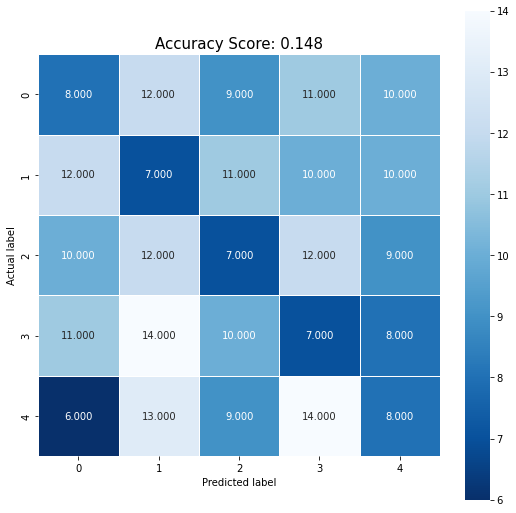

In [114]:
cm = confusion_matrix(y_test,predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm,annot=True, fmt='.3f', linewidths=.5, square=True,cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test,predictions))
plt.title(all_sample_title,size=15)

### Random Forest

##### Implementation

In [115]:
def RF(X_train, y_train, X_test, y_test):
    forest = RandomForestClassifier(criterion='gini',
                                    n_estimators=5,
                                    random_state=1,
                                    n_jobs=2)
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_test)
    print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
    return y_pred

In [116]:
def mat_of_conf(y_test,y_pred):
    cm = confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm,annot=True, fmt='.3f', linewidths=.5, square=True,cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test,y_pred))
    plt.title(all_sample_title,size=15)
    plt.show()

C:\Users\m.nedeljkovic\AppData\Local\Temp\ipykernel_19568\3284241286.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_train, y_train)


Accuracy: 0.192


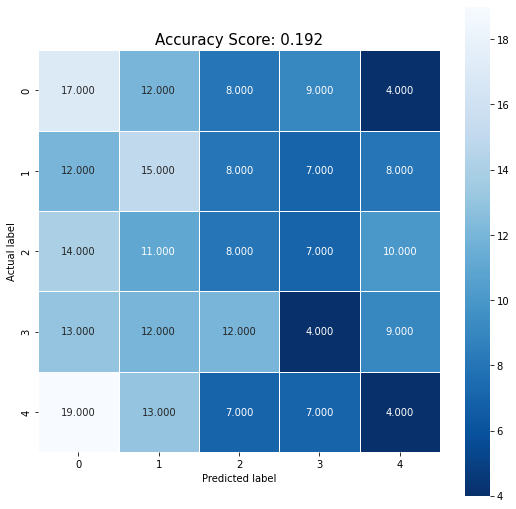

In [117]:
Forest = RF(X_train, y_train, X_test, y_test)
mat_of_conf(y_test,Forest)

### XG boost

In [118]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [123]:
model = XGBClassifier()
# fit the model
model.fit(X_train, y_train)
# evaluate performance
yhat = model.predict(X_test)
score = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % score)

Accuracy: 0.180
